# CM 50270 Reinforcement Learning: Coursework 2 

**Date set:** March 12, 2018 

**Date due:** 8 pm on March 21, 2018 

**Total number of marks:** 100. (This coursework will determine 20% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (.ipynb file) that includes all source code. Please do not change the file name.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Exercise 1: Blackjack (20 marks)

In this first exercise, you will implement **Monte Carlo Policy Evaluation (MCPE)** to learn the state-value function $V(s)$ for a given policy in the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack).

### The game

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

###  Blackjack code you may use if you wish

** Please feel free to skip this section and implement your own blackjack code **

We provide a `Blackjack` class that you can use to simulate blackjack games. The following cells in this section will walk you through the basic usage of this class by playing a couple of blackjack games.  

We import the blackjack module and create a blackjack environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the blackjack object will regularly print the progress of the game. This is useful for getting to know the game and the provided code or if you just want to play around. You may want to set `verbose=False` when you run thousands of episodes to complete the exercise below.

In [1]:
import blackjack
env = blackjack.Blackjack(verbose=True)

You can interact with the blackjack environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. Specifically, this method returns the resulting `new_state` and the corresponding `reward` signal.

Before the player can perform actions, we have to start the game (e.g., draw starting hands). In order to start or reset a blackjack game, call the `make_step()` without specifying a specific action or by setting `action="reset"`.

We will now walk through several example games. We will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) for the NumPy pseudo random number generator every time before we reset the game. This allows us to keep these examples reproducible.

In [2]:
import numpy as np
np.random.seed(8)
new_state, reward = env.make_step(action="reset")
print("Initial state:", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [10, 10]
Dealer's showing card: [7]
Initial state: [20  7  0]
Reward: 0


The player drew two cards with face value 10 each. The dealer also drew two cards, but we can only see the second card, a 7. The player now can choose to "hit" or "stick". Most players would stick if they had 20 on their hand. We call again the `make_step()` method and specify `action="stick"`.

In [3]:
new_state, reward = env.make_step(action = "stick")
print("The player obtains a reward of", reward)
print("The new (terminal) state is:", new_state)

The dealer's cards are: [10, 7]
The dealer has 17 points.
PLAYER WINS!
The player obtains a reward of 1
The new (terminal) state is: [-1 -1 -1]


The player won and received a reward of 1. Whenever an episode ends, the environment object sets the internal variable `self.active` to `False`. This variable is set to `True` again when we _reset_ the game. You can use the `self.active` variable to check whether an episode has ended or not.

In [4]:
np.random.seed(9)
new_state, reward = env.make_step(action="reset")
print("New state:", new_state)

The game is reset.
Player's cards: [11, 7]
Dealer's showing card: [2]
New state: [18  2  1]


The player has already 18 points but has a _usable ace_, which she can transfer into a 1 whenever she would _go bust_. The player can thus "hit" and hope that she gets closer to 21. 

In [5]:
new_state, reward = env.make_step(action = "hit")

Player draws card: [2]
New sum of player's cards: [20]


Great! The player got another 2 points and has again 20 points. The player would probably want to "stick" again...

In [6]:
new_state, reward = env.make_step(action = "stick")

The dealer's cards are: [7, 2]
The dealer has 9 points.
Dealer draws card: [3]
New dealer sum [12]
Dealer draws card: [6]
New dealer sum [18]
PLAYER WINS!


The player won again! Let's play a last one.

In [7]:
np.random.seed(7)
new_state, reward = env.make_step()
print("Reward:", reward)

The game is reset.
Player's cards: [11, 10]
Dealer's showing card: [10]
Player has Blackjack!
The dealer's cards are: [6, 10]
PLAYER WINS!
Reward: 1


The player drew a "Blackjack", that is, an ace and a 10. The dealer's cards valued 16. The player won again and received a reward without having performed an action. Try out some more games to get familiar with the code!

### Instructions

Your task is to learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."**. Your code should compute these state values using **Monte Carlo Policy Evaluation (MCPE)**. For your reference, the pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

You will have to provide a function `get_state_value(s, v)` that takes as input a state `s` (a numpy array of length 3 as described in the MDP formulation of blackjack) and the state values `v` that you computed. The `get_state_value(s, v)` should return the correponding state value $V(s)$ as a float. There are no restrictions on how you store the state values `v`.

We will mark your code by calling `get_state_value(s, v)` for different states valid states `s` in the _test cell_.

In [30]:
# This cell should compute the state values 'v' using MCPE.
import blackjack

env = blackjack.Blackjack(verbose=False)

def policy(state):
    if state[0] >= 19:
        action = "stick"
    else:
        action = "hit"
    return action

num_episodes = 10000

v = {}

for player_sum in range(12, 22):
    for dealer_sum in range(1, 11):
        for usable_ace in range(0, 2):
            v[(player_sum, dealer_sum, usable_ace)] = 0

#print(len(v))
#print(v)

rewards = v.copy()
visited_states = v.copy()

for episode in range(1, num_episodes + 1):
    state, _ = env.make_step(action="reset")
    while state[0] != -1:
        action = policy(state)
        new_state, reward = env.make_step(action)
        rewards[tuple(state)] += reward
        visited_states[tuple(state)] += 1
        state = new_state
 
#print(rewards)
#print(visited_states)

for key, value in v.items():
    v[key] = rewards[key] / visited_states[key]
for key, value in v.items():
    print("State: ", key, "\tValue: ", value)
    
#print(v)

State:  (12, 1, 0) 	Value:  -0.41935483870967744
State:  (12, 1, 1) 	Value:  0.0
State:  (12, 2, 0) 	Value:  -0.35789473684210527
State:  (12, 2, 1) 	Value:  0.0
State:  (12, 3, 0) 	Value:  -0.3854166666666667
State:  (12, 3, 1) 	Value:  0.0
State:  (12, 4, 0) 	Value:  -0.308411214953271
State:  (12, 4, 1) 	Value:  0.0
State:  (12, 5, 0) 	Value:  -0.2926829268292683
State:  (12, 5, 1) 	Value:  0.0
State:  (12, 6, 0) 	Value:  -0.3125
State:  (12, 6, 1) 	Value:  0.0
State:  (12, 7, 0) 	Value:  -0.18085106382978725
State:  (12, 7, 1) 	Value:  0.0
State:  (12, 8, 0) 	Value:  -0.32051282051282054
State:  (12, 8, 1) 	Value:  0.0
State:  (12, 9, 0) 	Value:  -0.2882882882882883
State:  (12, 9, 1) 	Value:  0.0
State:  (12, 10, 0) 	Value:  -0.2784090909090909
State:  (12, 10, 1) 	Value:  0.0
State:  (13, 1, 0) 	Value:  -0.4482758620689655
State:  (13, 1, 1) 	Value:  0.0
State:  (13, 2, 0) 	Value:  -0.4574468085106383
State:  (13, 2, 1) 	Value:  0.0
State:  (13, 3, 0) 	Value:  -0.4042553191489361

In [36]:
# Complete the function definition for get_state_value(s,v) in this cell.
def get_state_value(s, v):
    
    state = tuple(s)
    value_of_s = v[state]
    
    return value_of_s

print(get_state_value([20,8,0], v))


0.835820895522388


In [ ]:
# This is the TEST CELL for Exercise 1. We will use it to mark your solution. 
# All of your code for Exercise 1 must be written above this cell. 

## Exercise 2: Tic-Tac-Toe (80 marks)

In this exercise you will implement the game of [Tic-Tac-Toe](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as _noughts and crosses_) and learn an optimal policy using **Q-learning**. You will then implement **SARSA** and compare the two learning approaches with each other.

### The game

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

### Instructions
Implement the game of Tic-Tac-Toe. The first-moving player is randomly chosen at the beginning of each episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero; do not discount ($\gamma = 1$). Player X will always be played by a _random agent_. This agent randomly chooses one of the empty grid spaces and marks it with "X". You will implement different agents for Player O.

We will ask you to plot your results and to discuss the produced plots. Please make sure to **label your figures appropriately**. Please only use plotting packages that come pre-installed with Anaconda 3. We recommend the package `matplotlib` (the tutorial provided in the first lab contains a whole section on matplotlib).

### Exercise 2a: Random policy against a random policy (10 marks)
Test your Tic-Tac-Toe implementation by letting two random agents play against each other. Plot the cumulative rewards of both O and X as a function of the number of episodes played. 

In [220]:
import numpy as np
import random

class Tictactoe():
    
    def __init__(self):
        self.players = {"O": 1, "X": 2}
        self.winners = np.array([
            [0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]
            ])
        self.board = self.create_board()
        self.winner = None

    def create_board(self):
        return np.zeros(9, dtype=int)

    def print_board(self):
        b = np.reshape(self.board, (3,3))
        print(b)

    def get_available_actions(self):
        valid_moves = []

        for i in range(9):
            if self.board[i] == 0:
                valid_moves.append(i)
        
        return valid_moves

    def make_move(self, player, move):
        piece = self.players[player]
        #print(piece)
        self.board[move] = piece
    
    def get_winner(self):
        return self.winner
    
    def get_reward(self):
        if self.winner == 0:
            return 0
        elif self.winner == 1:
            return 1
        elif self.winner == 2:
            return -1

    def is_finished(self):
        for _, player in self.players.items():
            for row in self.winners:
                if all([self.board[cell] == player for cell in row]):
                    # A player has won
                    self.winner = player
                    return True

        for i in range(9):
            if self.board[i] == 0:
                return False # No one has won yet

        # Otherwise, game is a draw
        self.winner = 0
        return True


In [215]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def choose_action(self, available_actions):
        return random.choice(available_actions)

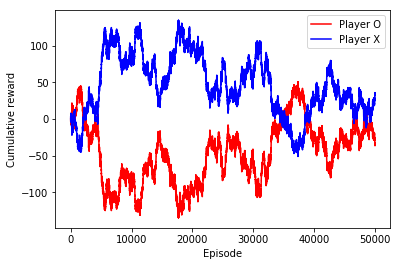

In [218]:
### Your code for Exercise 2a
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


def play():
    env = Tictactoe()
    r = RandomAgent()
    p = list(env.players.items())
    random.shuffle(p)
    for player, _ in itertools.cycle(p):
        available_actions = env.get_available_actions()
        move = r.choose_action(available_actions)
        env.make_move(player, move)
        if env.is_finished():
            reward = env.get_reward()
            return reward

num_episodes = 50000

results_O = np.zeros(num_episodes)
results_X = np.zeros(num_episodes)

for episode in range(num_episodes):
    reward = play()
    if reward == 0:
        results_O[episode] = reward
        results_X[episode] = reward
    elif reward == 1:
        results_O[episode] = reward
        results_X[episode] = -reward
    elif reward == -1:
        results_O[episode] = reward
        results_X[episode] = -reward

cum_results_O = np.cumsum(results_O)
cum_results_X = np.cumsum(results_X)

plt.plot(cum_results_O, color="red", label="Player O")
plt.plot(cum_results_X, color="blue", label="Player X")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

In a few sentences, discuss your results. Did you expect these results? Why or why not? (We will mark only the first three sentences. Please do not write any longer than that.) 

The cumulative returns of player O and X are equal and opposite, as expected for Tic-tac-toe which is a zero-sum game. Neither player has a clear advantage as the number of episodes increases because both players are random and who moves first is also random.



### Exercise 2b: Q-learning (20 marks)
Use Q-learning to learn an optimal policy for playing Tic-Tac-Toe against a random opponent. Produce a learning curve for your agent. That is, (1) plot average return as a function of episodes, (2) the learning curve should plot the average return of many agents (please specify how many agents you are averaging). 

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>
 

In [222]:
class QLearningAgent():
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}
        self.q = np.zeros((19683, 9))
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
        
    def reset(self):
        self.prev_state = None
        self.prev_q = 0.0
        self.prev_state_action = None
    
    def convert(self, state):
        conversion_vector = 3 ** np.arange(9)
        return int(state.dot(conversion_vector))
    
    def choose_action(self, available_actions, state):
        #self.prev_state = state
        s = self.convert(state)
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            #self.prev_q = self.getQ(self.prev_state, action)
            #self.prev_state_action = (self.prev_state, action)
            return action
        else:
            qs = [self.getQ(s, action) for action in available_actions]
            #if not qs:
            #print("qs:", qs)
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]
        #self.prev_q = self.getQ(self.prev_state, action)
        #self.prev_state_action = (self.prev_state, action)
        return action
    
    #def getQ(self, state, action):
    #    if(self.Q.get((state, action))) is None:
    #        self.Q[(state, action)] = 0.0
    #    return self.Q.get((state,action))
    
    def getQ(self, state, action):
        #s = self.convert(state)
        return self.q[state][action]
    
    def updateQ(self, state, new_state, reward, action, available_actions):
        s = self.convert(state)
        s_ = self.convert(new_state)
        #print(self.q[s])
        qs = []
        for a in available_actions:
            qs.append(self.getQ(s_, a))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0
        #print("qs:", qs, "\tMax q:", max_next_Q)
        #print("Current Q:", self.Q.get((state, action), 0))
        #self.Q[(state, action)] = ((1 - self.alpha) * self.Q.get((state, action), 0)) + (self.alpha * (reward + self.gamma * max_next_Q))
        self.q[s][action] = ((1 - self.alpha) * self.q[s][action]) + (self.alpha * (reward + self.gamma * max_next_Q))
        #print("Updated Q:", self.Q.get((state, action), 0))
        #print(self.q[s])

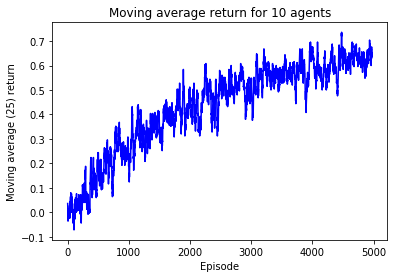

In [223]:
### Use this cell to produce the learning curve for Exercise 2b
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


def play(q_agent, random_agent, n_episodes):
    for episode in range(n_episodes):

        reward = 0
        env = Tictactoe()
        players = ["O", "X"]
        # Shuffle the players to get a random start
        random.shuffle(players)
        
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("X", action)
            
        while not env.is_finished():
            state = np.copy(env.board)
            #print(state)

            # Q-learning agent makes a move
            available_actions = env.get_available_actions()
            action = q_agent.choose_action(available_actions, state)
            env.make_move("O", action)
            new_state = np.copy(env.board)
            
            # If game is finished, random agent cannot make a move
            if env.is_finished():
                #print(new_state)
                reward = env.get_reward()
                reward_array[episode] += reward

            else:
                # Random agent makes a move
                available_actions = env.get_available_actions()
                chosen_action = random_agent.choose_action(available_actions)
                env.make_move("X", chosen_action)
                new_state = np.copy(env.board)
                #print(new_state)
            
                #winner = env.check_win()
                if env.is_finished():
                    reward = env.get_reward()
                    reward_array[episode] += reward

            available_actions = env.get_available_actions()
            #print(state, new_state, reward, action, available_actions)
            q_agent.updateQ(state, new_state, reward, action, available_actions)
            #print("Q value:", q_agent.Q[(tuple(state), action)])
    
    Q_array.append(q_agent.q)

    
alpha = 0.1
gamma = 1
epsilon = 0.1
#initial_Q = 0

n_episodes = 5000
n_agents = 10

reward_array = np.zeros(n_episodes)
Q_array = []

# Game loop for each agent
for i in range(n_agents):

    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha, gamma, epsilon)
    
    play(q_agent, random_agent, n_episodes)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array = moving_average(reward_array) / n_agents

plt.plot(moving_average_array, color="blue", label="Average for 10 agents")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (25) return")
#plt.legend()
plt.show()

In 3 sentences or less, (1) explain the state representation you used, (2) discuss the learning curve you produced. 


### Exercise 2c: Optimal policy (20 marks)
What is the optimal play for the agent in the following state? You must answer by writing a function that takes a state as input and _prints_ the "after-state" that would result from playing an optimal action. The printed output can be primitive but the board has to be somewhat recognizable.   <img src="images/tic_tac_toe.png" style="width: 80px;"/> 

In [167]:
def convert(board):
    return board[0] * (3**8) + board[1] * (3**7) + board[2] * (3**6) + board[3] * (3**5) + board[4] * (3**4) \
        + board[5] * (3**3) + board[6] * (3**2) + board[7] * (3**1) + board[8] * (3**0)

def convert2(board):
    conversion_vector = 3 ** np.arange(9)
    return int(board.dot(conversion_vector))

boards = []    

for a in [0,1,2]:
    for b in [0,1,2]:
        for c in [0,1,2]:
            for d in [0,1,2]:
                for e in [0,1,2]:
                    for f in [0,1,2]:
                        for g in [0,1,2]:
                            for h in [0,1,2]:
                                for i in [0,1,2]:
                                    board = np.array([a,b,c,d,e,f,g,h,i])
                                    #boards.append(board)
                                    print(convert(board))
                                    print(convert2(board))

ternary_state = np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])

#print(boards.index(ternary_state))

conversion_vector = 3 ** np.arange(9)
print(conversion_vector)
print(int(ternary_state.dot(conversion_vector)))

q = np.zeros((19683, 9))
#for i in range(19683):
#    print(q[i])
                                    

0
0
1
6561
2
13122
3
2187
4
8748
5
15309
6
4374
7
10935
8
17496
9
729
10
7290
11
13851
12
2916
13
9477
14
16038
15
5103
16
11664
17
18225
18
1458
19
8019
20
14580
21
3645
22
10206
23
16767
24
5832
25
12393
26
18954
27
243
28
6804
29
13365
30
2430
31
8991
32
15552
33
4617
34
11178
35
17739
36
972
37
7533
38
14094
39
3159
40
9720
41
16281
42
5346
43
11907
44
18468
45
1701
46
8262
47
14823
48
3888
49
10449
50
17010
51
6075
52
12636
53
19197
54
486
55
7047
56
13608
57
2673
58
9234
59
15795
60
4860
61
11421
62
17982
63
1215
64
7776
65
14337
66
3402
67
9963
68
16524
69
5589
70
12150
71
18711
72
1944
73
8505
74
15066
75
4131
76
10692
77
17253
78
6318
79
12879
80
19440
81
81
82
6642
83
13203
84
2268
85
8829
86
15390
87
4455
88
11016
89
17577
90
810
91
7371
92
13932
93
2997
94
9558
95
16119
96
5184
97
11745
98
18306
99
1539
100
8100
101
14661
102
3726
103
10287
104
16848
105
5913
106
12474
107
19035
108
324
109
6885
110
13446
111
2511
112
9072
113
15633
114
4698
115
11259
116
17820
117
1053
118

18207
1440
1440
1441
8001
1442
14562
1443
3627
1444
10188
1445
16749
1446
5814
1447
12375
1448
18936
1449
2169
1450
8730
1451
15291
1452
4356
1453
10917
1454
17478
1455
6543
1456
13104
1457
19665
1458
18
1459
6579
1460
13140
1461
2205
1462
8766
1463
15327
1464
4392
1465
10953
1466
17514
1467
747
1468
7308
1469
13869
1470
2934
1471
9495
1472
16056
1473
5121
1474
11682
1475
18243
1476
1476
1477
8037
1478
14598
1479
3663
1480
10224
1481
16785
1482
5850
1483
12411
1484
18972
1485
261
1486
6822
1487
13383
1488
2448
1489
9009
1490
15570
1491
4635
1492
11196
1493
17757
1494
990
1495
7551
1496
14112
1497
3177
1498
9738
1499
16299
1500
5364
1501
11925
1502
18486
1503
1719
1504
8280
1505
14841
1506
3906
1507
10467
1508
17028
1509
6093
1510
12654
1511
19215
1512
504
1513
7065
1514
13626
1515
2691
1516
9252
1517
15813
1518
4878
1519
11439
1520
18000
1521
1233
1522
7794
1523
14355
1524
3420
1525
9981
1526
16542
1527
5607
1528
12168
1529
18729
1530
1962
1531
8523
1532
15084
1533
4149
1534
10710
1535

12099
2636
18660
2637
1893
2638
8454
2639
15015
2640
4080
2641
10641
2642
17202
2643
6267
2644
12828
2645
19389
2646
678
2647
7239
2648
13800
2649
2865
2650
9426
2651
15987
2652
5052
2653
11613
2654
18174
2655
1407
2656
7968
2657
14529
2658
3594
2659
10155
2660
16716
2661
5781
2662
12342
2663
18903
2664
2136
2665
8697
2666
15258
2667
4323
2668
10884
2669
17445
2670
6510
2671
13071
2672
19632
2673
57
2674
6618
2675
13179
2676
2244
2677
8805
2678
15366
2679
4431
2680
10992
2681
17553
2682
786
2683
7347
2684
13908
2685
2973
2686
9534
2687
16095
2688
5160
2689
11721
2690
18282
2691
1515
2692
8076
2693
14637
2694
3702
2695
10263
2696
16824
2697
5889
2698
12450
2699
19011
2700
300
2701
6861
2702
13422
2703
2487
2704
9048
2705
15609
2706
4674
2707
11235
2708
17796
2709
1029
2710
7590
2711
14151
2712
3216
2713
9777
2714
16338
2715
5403
2716
11964
2717
18525
2718
1758
2719
8319
2720
14880
2721
3945
2722
10506
2723
17067
2724
6132
2725
12693
2726
19254
2727
543
2728
7104
2729
13665
2730
2730
273

12981
3806
19542
3807
183
3808
6744
3809
13305
3810
2370
3811
8931
3812
15492
3813
4557
3814
11118
3815
17679
3816
912
3817
7473
3818
14034
3819
3099
3820
9660
3821
16221
3822
5286
3823
11847
3824
18408
3825
1641
3826
8202
3827
14763
3828
3828
3829
10389
3830
16950
3831
6015
3832
12576
3833
19137
3834
426
3835
6987
3836
13548
3837
2613
3838
9174
3839
15735
3840
4800
3841
11361
3842
17922
3843
1155
3844
7716
3845
14277
3846
3342
3847
9903
3848
16464
3849
5529
3850
12090
3851
18651
3852
1884
3853
8445
3854
15006
3855
4071
3856
10632
3857
17193
3858
6258
3859
12819
3860
19380
3861
669
3862
7230
3863
13791
3864
2856
3865
9417
3866
15978
3867
5043
3868
11604
3869
18165
3870
1398
3871
7959
3872
14520
3873
3585
3874
10146
3875
16707
3876
5772
3877
12333
3878
18894
3879
2127
3880
8688
3881
15249
3882
4314
3883
10875
3884
17436
3885
6501
3886
13062
3887
19623
3888
48
3889
6609
3890
13170
3891
2235
3892
8796
3893
15357
3894
4422
3895
10983
3896
17544
3897
777
3898
7338
3899
13899
3900
2964
3901


KeyboardInterrupt: 

In [225]:
### You may use this code cell to answer Exercise 2c.

'''def optimal_policy(state):
    #count1 = 0
    #count2 = 0
    best_action = 9
    best_value = 0
    for Q_table in Q_array:
        print("test")
        for key, value in Q_table.items():
            #count1 += 1
            #print(key)
            if key[0] == tuple(state):
                if value > best_value:
                    best_action = key[1]
                #print("Found")
                print("Action:", key[1], "Value", value)
            #if value > 0:
            #    count2 += 1
    
    state[best_action] = 1
    print(np.reshape(state, (3,3)))
    
    #print(count1)
    #print(count2)'''

def convert(state):
    conversion_vector = 3 ** np.arange(9)
    return int(state.dot(conversion_vector))

def optimal_policy(state):
    sum_q = np.zeros((19683, 9))
    for Q_table in Q_array:
        print(Q_table[state])
        sum_q = np.add(sum_q, Q_table)
    avg_q = sum_q / n_agents
    #print(sum_q)
    #print(avg_q)
    print(avg_q[state])

state = np.array([1, 2, 0, 0, 2, 0, 0, 1, 0])
s = convert(state)
#b = np.reshape(state, (3,3))
#print(b)
optimal_policy(s)

#print("")

#state = np.array([2, 1, 2, 0, 1, 2, 0, 0, 0])
#s = convert(state)
#optimal_policy(s)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]


Please ignore this cell. We will use this cell to mark your answer. 


### Exercise 2d: Sarsa (40 marks)
Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Also include the learning curve of your previously trained Q-learning agent in the same plot. Discuss the learning curves. For your reference, the pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>



In [226]:
class SarsaAgent():
    
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = np.zeros((19683, 9))
    
    def convert(self, state):
        conversion_vector = 3 ** np.arange(9)
        return int(state.dot(conversion_vector))
    
    def choose_action(self, available_actions, state):
        #self.prev_state = state
        s = self.convert(state)
        
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(available_actions)
            return action
        else:
            qs = [self.getQ(s, action) for action in available_actions]
            maxQ = max(qs)
            if qs.count(maxQ) > 1:
                best = [i for i in range(len(available_actions)) if qs[i] == maxQ]
                i = random.choice(best)
            else:
                i = qs.index(maxQ)
        
        action = available_actions[i]

        return action
    
    
    def getQ(self, state, action):
        return self.q[state][action]
    
    def update(self, state, new_state, reward, action, action_):
        s = self.convert(state)
        s_ = self.convert(new_state)
        #print(self.q[s])
        '''qs = []
        for a in available_actions:
            qs.append(self.getQ(s_, a))
        if qs:
            max_next_Q = max(qs)
        else:
            max_next_Q = 0.0'''
        
        self.q[s][action] = ((1 - self.alpha) * self.q[s][action]) + (self.alpha * (reward + self.gamma * self.q[s_][action_]))


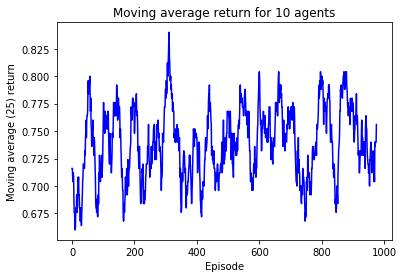

In [227]:
### Use this cell to produce the learning curve for Exercise 2d
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


def play(q_agent, random_agent, n_episodes):
    for episode in range(n_episodes):

        reward = 0
        env = Tictactoe()
        players = ["O", "X"]
        # Shuffle the players to get a random start
        random.shuffle(players)
        
        # If first player is the random agent, make a move
        if players[0] == "X":
            available_actions = env.get_available_actions()
            action = random_agent.choose_action(available_actions)
            env.make_move("X", action)
            
        # Choose a
        available_actions = env.get_available_actions()
        action = sarsa_agent.choose_action(available_actions, state)
            
        while not env.is_finished():
            state = np.copy(env.board)
            #print(state)

            # Q-learning agent makes a move
            env.make_move("O", action)
            # Observe new state
            new_state = np.copy(env.board)
            # Observe reward
            if env.is_finished():
                reward = env.get_reward()
                reward_array[episode] += reward

            # Random agent makes a move
            available_actions = env.get_available_actions()
            chosen_action = random_agent.choose_action(available_actions)
            env.make_move("X", chosen_action)
            # Observe new state
            new_state = np.copy(env.board)
            #print(new_state)

            if env.is_finished():
                reward = env.get_reward()
                reward_array[episode] += reward

            #available_actions = env.get_available_actions()
            #print(state, new_state, reward, action, available_actions)
            q_agent.update(state, new_state, reward, action, next_action)
            #print("Q value:", q_agent.Q[(tuple(state), action)])
    
    Q_array.append(q_agent.q)

    
alpha = 0.1
gamma = 1
epsilon = 0.1
#initial_Q = 0

n_episodes = 1000
n_agents = 10

reward_array = np.zeros(n_episodes)
Q_array = []

# Game loop for each agent
for i in range(n_agents):

    random_agent = RandomAgent()
    sarsa_agent = SarsaAgent(alpha, gamma, epsilon)
    
    play(q_agent, random_agent, n_episodes)
    

# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_array = moving_average(reward_array) / n_agents

plt.plot(moving_average_array, color="blue", label="Average for 10 agents")
plt.title("Moving average return for "+ str(n_agents) + " agents")
plt.xlabel("Episode")
plt.ylabel("Moving average (25) return")
#plt.legend()
plt.show()

Discuss the learning curves here in 10 sentences or less.
